Previously, we left off implementing data acquitition, cleaup and data preprocessing. Through the functionality we built in the last article, we have built our **corpus**. Next, we will attempt indexing our data!

## Where we left off

In the [previous page](/blog/search-engine-1), we implemented data acquisition and data cleanup. We are now able to recursively walk through the directory of enron emails (or other text files), clean up some data, and break text up into a list of words.

Now, our goal is to work towards indexing our data.

## Reverse Index

The primary way of building a search engine is through building a **reverse index**.

> **Reverse index**: a data structure, which is similar to a hash table, but reverse. In search engines, we can use a reverse index to map a term to the documents it appears in

Let's try prototyping a reverse index using a map!

```javascript
import unicode from "./unicode.js";

class Indexer {
  constructor() {
    this.idx = new Map();
  }

  index(document) {
    // Let's get the content of the sections
    const text = document
      .getSections()
      .map(section => section.getContent())
      .join('\n');
  
    // clean up and preprocess the document and deduplicate words
    const wordSet = new Set();
    unicode
      .wordlist(unicode.transliterate(text))
      .forEach(word => {
        wordSet.add(word);
      });
    

    for (const word of wordSet) {
      if (!this.idx.has(word)) {
        this.idx.set(word, []);
      }

      this.idx
        .get(word)
        .push(document.getUri());
    }
  }

  getIndex() {
    return this.idx;
  }
}

export default Indexer;
```

Chief, we've got a bit of a situation... $1,060,703$ terms are in our vocabulary! And our index is so large, we can't even write it to a JSON file to inspect!

```
Enter a string to search: debug
1060703
file:///Users/yash/code/microsearch/runner.js:78
      fs.writeFile('debug.json', JSON.stringify(Object.fromEntries(index.idx), null, 2));
                                      ^

RangeError: Invalid string length
    at JSON.stringify (<anonymous>)
    at file:///Users/yash/code/microsearch/runner.js:78:39
    at process.processTicksAndRejections (node:internal/process/task_queues:105:5)

Node.js v22.13.0
```

Additionally, the memory usage of node is *insane*!
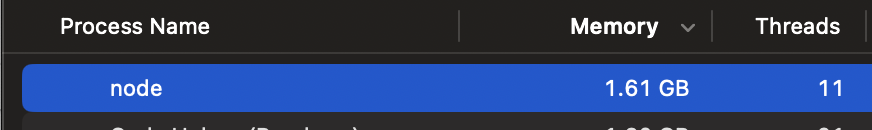

The actual reverse index is so big that we can't handle it! Just the enron emails dataset resulted in a reverse index with $1060703$ words! For a reverse index to be practical, we will need to prune it and keep only what we need! We will circle back to optimization in the next article.

###### TODO: add a demo of the indexer

### Improving our Preprocessing

Before we start improving our preprocessing, let's inspect our current index. Since the full index is too large to inspect, I modified my search indexer to only index the first 1000 documents. Here is a snapshot of just a few entries in our index:

```
"mobile:", "sure,", "of.", "-ina", "curless,", "amanda", "ina,", "reception.", "mandy", "form.doc", "filled", "pleae", "announcements.enron@enron.com", "dl-ga-all_domestic@enron.com", "</o=enron/ou=na/cn=recipients/cn=mbx_anncenron>", "dl-ga-all_domestic", "</o=enron/ou=na/cn=recipients/cn=dl-ga-all_enron_north_america>", "around,", "credible", "advocate", "print", "reporters.", "links", "stories", "interviews.", "times:", "suits", "http://home.enron.com/updates/articles/lawsuits.html", "ap", "online:", "rebirth", "http://home.enron.com/updates/articles/notimpossible.html", "wire:", "salvaged:", "collapsed", "faces", "hurdles", "http://home.enron.com/updates/articles/salvaged.html"
```

The current preprocessing algorithm isn't working well. There are a lot of long terms which really don't mean much. Additionally, the old code had a bug where it was splitting up numbers into digits. Can we improve our code?

Let's make some changes:

1. Lets NFKC normalization before NFD to further clean up unicode
2. Lets replace `\p{Emoji}` with `\p{Emoji_Presentation}|\p{Extended_Pictographic}` since that was treating numbers as emojis.
3. Lets use a regex to replace special characters with spaces

Try the new preprocessing algorithm below:

> **NFKC**:
>
> Normalization Form KC - Compatibility decomposition followed by canonical composition
> 
> Read [this article](https://unicode.org/reports/tr15/) for more information

> **NFD**:
>
> Normalization Form D - Canonical decomposition
>  
> Read [this article](https://unicode.org/reports/tr15/) for more information

After these changes, we are left with a vocabulary size of $303209$ terms, much better than the 1M+ terms we had before!

## Searching Using a Reverse Index

Searching using a reverse index is quite simple and efficient.

1. Normalize the search query to the reverse index. This is fancy speak for use the exact same methods to process the search query as the contents of the reverse index.
2. Create a hash map to map each document found to the number times it was found.
3. Add a document to the hash map if it is a hit and increment its hit count (score)
4. Rank the documents based on these scores

Let's implement it!

```javascript
query(searchQuery) {
  if (!searchQuery)
    return [];

  const terms = new Set(unicode.wordlist(unicode.transliterate(searchQuery)));

  const unrankedResults = new Map();
  for (const term of terms) {
    const hits = this.idx.get(term) || [];
    for (const hit of hits) {
      const current = unrankedResults.get(hit) || 0;
      unrankedResults.set(hit, current + 1);
    }
  }

  const arr = Array
    .from(unrankedResults
      .entries()
      .map(([ document, hits ]) => ({
        document,
        hits,
      })));

  return arr.sort((a, b) => b.hits - a.hits);
}
```

Try it in the demo below!

## Search Demo (I indexed 5 documents)

## Reverse Index Optimization | Can we do Better?

Reverse indexes are sort of the perfect search engine. They know everything and if a word exists in a document somewhere, the reverse index will have it. But the problem is that they don't scale! A reverse index may become untenable once holding a couple thousand documents. So how can we optimize a reverse index and shrink it?

### Not all Words are Equal

If we take a look at the inverse index created by our naive approach, we see that there is a lot of junk and useless words.

Moreover, in most languages such as English, we use lots of words which add little meaning. Just in the last sentence, think abuot what value the following words add: { moreover, in, most, such, as, we, use, lots, of }. What can we do to prune our reverse index and only store what matters?

However, the elephant in the room - our preprocessing algorithm is still not as good as necessary. Example: `</o=enron/ou=na/cn=recipients/cn=dl-ga-all_enron_north_america>`. Below, play around with my updated regexps.



## Thoughts scratchpad



English and most languages are quite wordy. We can remove a lot of the common words since they add little value to the context. But how do we know what value a word adds to the context? There are a few different methods that we can use:

* **TF-IDF (Term Frequency-Inverse Document Frequency)**: among the simplest of the ranking functions. Many of the more sophisticated ranking functions are variants of this.
* **BM25 (Okapi BM25)**: refined version of TF-IDF, which adds saturation and frequency normalization.
* **Word Embeddings (Word2vec, GloVe, FastText)**: capture semantics instead of just term frequency, but more expensive to compute
* **Entropy-Based Weighting**: measures how uniformly a word appears in documents. Words appearing across more documents are likely less important

There are many more methods, some even involving machine learning. However, for simplicity, we will use TF-IDF in this project, and may switch it out for a better method later on.